In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import PIL
import numpy as np
import PIL.Image
import time
import functools
import os
import scipy
import time
import matplotlib.image as mpimg

In [0]:
from google.colab import drive
drive.mount("/content/drive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80142336/80134624 [==============================] - 3s 0us/step


Define <font color='purple'> *tensor_to_image*</font>

In [0]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [0]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


### **Visualize input image**   
Define <font color='purple'>*load_image*</font>

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Define <font color='purple'>*imshow*</font>

In [0]:
def imshow(img, title=None):
  if len(img.shape)>3:
    img = tf.squeeze(img, axis=0)
  plt.imshow(img)
  if title:
    plt.title(title)

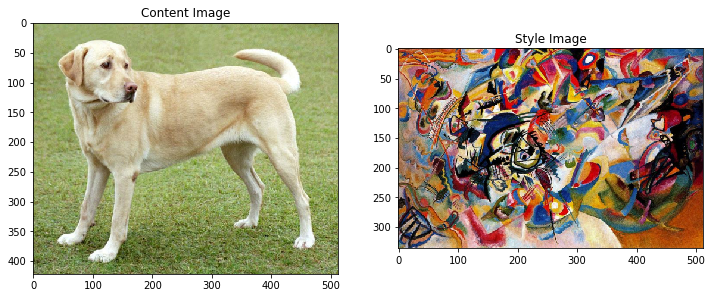

In [0]:
content_img = load_img(content_path)
style_img = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_img, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_img, 'Style Image')

Define <font color='purple'>*get_files*</font>

In [0]:
def get_files(img_dir):
  files = []
  for(dirpath, dirnames, filenames) in os.walk(img_dir):
    files.extend(filenames)
    break
  return list(map(lambda x: os.path.join(img_dir,x), files))

In [0]:
WEIGHTS_INIT_STDEV = .1

def net(image):
    conv1 = _conv_layer(image, 32, 9, 1)
    conv2 = _conv_layer(conv1, 64, 3, 2)
    conv3 = _conv_layer(conv2, 128, 3, 2)
    resid1 = _residual_block(conv3, 3)
    resid2 = _residual_block(resid1, 3)
    resid3 = _residual_block(resid2, 3)
    resid4 = _residual_block(resid3, 3)
    resid5 = _residual_block(resid4, 3)
    conv_t1 = _conv_tranpose_layer(resid5, 64, 3, 2)
    conv_t2 = _conv_tranpose_layer(conv_t1, 32, 3, 2)
    conv_t3 = _conv_layer(conv_t2, 3, 9, 1, relu=False)
    preds = tf.nn.tanh(conv_t3) * 150 + 255./2
    return preds

def _conv_layer(net, num_filters, filter_size, strides, relu=True):
    weights_init = _conv_init_vars(net, num_filters, filter_size)
    strides_shape = [1, strides, strides, 1]
    net = tf.nn.conv2d(net, weights_init, strides_shape, padding='SAME')
    net = _instance_norm(net)
    if relu:
        net = tf.nn.relu(net)

    return net

def _conv_tranpose_layer(net, num_filters, filter_size, strides):
    weights_init = _conv_init_vars(net, num_filters, filter_size, transpose=True)

    batch_size, rows, cols, in_channels = [i.value for i in net.get_shape()]
    new_rows, new_cols = int(rows * strides), int(cols * strides)
    # new_shape = #tf.pack([tf.shape(net)[0], new_rows, new_cols, num_filters])

    new_shape = [batch_size, new_rows, new_cols, num_filters]
    tf_shape = tf.stack(new_shape)
    strides_shape = [1,strides,strides,1]

    net = tf.nn.conv2d_transpose(net, weights_init, tf_shape, strides_shape, padding='SAME')
    net = _instance_norm(net)
    return tf.nn.relu(net)

def _residual_block(net, filter_size=3):
    tmp = _conv_layer(net, 128, filter_size, 1)
    return net + _conv_layer(tmp, 128, filter_size, 1, relu=False)

def _instance_norm(net, train=True):
    batch, rows, cols, channels = [i.value for i in net.get_shape()]
    var_shape = [channels]
    mu, sigma_sq = tf.nn.moments(net, [1,2], keep_dims=True)
    shift = tf.Variable(tf.zeros(var_shape))
    scale = tf.Variable(tf.ones(var_shape))
    epsilon = 1e-3
    normalized = (net-mu)/(sigma_sq + epsilon)**(.5)
    return scale * normalized + shift

def _conv_init_vars(net, out_channels, filter_size, transpose=False):
    _, rows, cols, in_channels = [i.value for i in net.get_shape()]
    if not transpose:
        weights_shape = [filter_size, filter_size, in_channels, out_channels]
    else:
        weights_shape = [filter_size, filter_size, out_channels, in_channels]

    weights_init = tf.Variable(tf.truncated_normal(weights_shape, stddev=WEIGHTS_INIT_STDEV, seed=1), dtype=tf.float32)
    return weights_init

In [0]:

def save_image(image, file_path):
    '''
    Save an image as a jpg file. The image is given as 
    a numpy array with pixel values between 0 and 255.
    
    :param image:
        The numpy array of the image.
        type: ndarray
    :param file_path:
        The full path to save the mixed image, 
        i.e. image path + image name
        type: str
    :return:
        Save the image as a jpeg file.
    '''
    
    # Ensure the pixel values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image file in jpeg format.e
    with open(file_path, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

In [0]:
def feed_forward(image_path, output_path, checkpoint_dir, style_path=None, movie=False):
    '''
    Since we already have a pre-trained checkpoint, we could 
    just use it to generate a mixed image.
    
    :param image_path:
        The path and filename that you are going to tranfer.
        type: str
    :param style_path:
        The path and filename of the style image.
        This is just for displaying and has nothing with 
        the evaluation.
        type: str
    :param output_path:
        The path to store the mixed image, including its filename.
        type: str
    :param checkpoint_dir:
        The path and filename of the pre-trained checkpoint.
        type: str
    :return:
        Save the mixed image and display image.
    '''
    
    # Build a graph and a session.
    with tf.Graph().as_default(), tf.Session() as sess:
        # Read content image from a file as a numpy array.
        if movie:
          content_image = image_path
        else:
          content_image = mpimg.imread(image_path)

        # Read style image from a file if provided.
        if style_path is not None:
            style_image = mpimg.imread(style_path)
        
        # Since image transform net requires a 4-D array,
        # we'll have to expand a dimension at axis = 0.
        content_image = np.expand_dims(content_image, axis=0)
        
        # Define a 4-D placeholder for image.
        image_holder = tf.placeholder(
            tf.float32, content_image.shape, 'input_image')
        
        # Let image flow through image transform net.
        output_image = net(image_holder)
        
        # Restore the pre-trained checkpoint.
        saver = tf.train.Saver()
        saver.restore(sess, checkpoint_dir)
        
        # Run the session.
        feed_dict = {image_holder: content_image}
        mixed_image = sess.run(output_image, feed_dict)
        #return mixed_image[0]

        
        # Save the mixed image.
        with open(output_path, 'wb') as file:
            save_image(mixed_image[0], output_path)
        
        # If style image is provided, display content, mixed, style image.
        if style_path is not None:
            fig, axes = plt.subplots(1, 3, figsize=(20, 20))
            
        # If style image is not provided, display content, mixed image.
        else:
            fig, axes = plt.subplots(1, 2, figsize=(20, 20))
        
        # Use interpolation to smooth pixels
        smooth = True

        # Interpolation type.
        if smooth:
            interpolation = 'sinc'
        else:
            interpolation = 'nearest'
            
        # Plot the content image.
        # Note that the pixel values are normalized to
        # the [0.0, 1.0] range by dividing with 255.
        ax = axes.flat[0]
        ax.imshow(content_image[0] / 255.0, interpolation=interpolation)
        ax.set_xlabel('Content')

        # Plot the mixed image.
        ax = axes.flat[1]
        ax.imshow(mixed_image[0] / 255.0, interpolation=interpolation)
        ax.set_xlabel('Mixed')
        
        if style_path is not None:
            # Plot the style image
            ax = axes.flat[2]
            ax.imshow(style_image / 255.0, interpolation=interpolation)
            ax.set_xlabel("Style")
        
        # Remove ticks from all the plots.
        for ax in axes.flat:
            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
        plt.show()
        return mixed_image
        
        

In [0]:
#!pip3 install --upgrade --force-reinstall tensorflow-gpu

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/la_muse.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


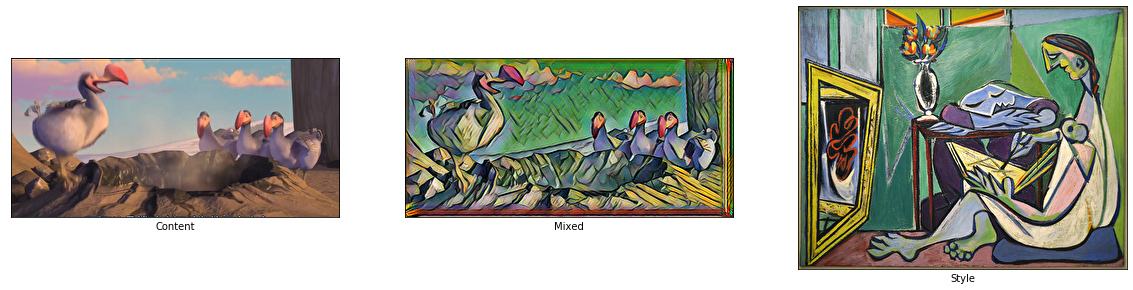

In [0]:
# use pre_trained model to generate stylized image
INPUT_PATH = '/content/drive/My Drive/MML/image/content/movie/1.jpg'
OUTPUT_PATH = '/content/drive/My Drive/MML/image/stylized/hoovertowernight_la_muse.jpg'
CHECKPOINT_DIR = '/content/drive/My Drive/MML/Fast Style Transfer Models/la_muse.ckpt'
STYLE_PATH = '/content/drive/My Drive/MML/image/style/la_muse.jpg' # Optional. Only for displaying it.

# Run the code.
feed_forward(INPUT_PATH, OUTPUT_PATH, CHECKPOINT_DIR, STYLE_PATH)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/scream.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


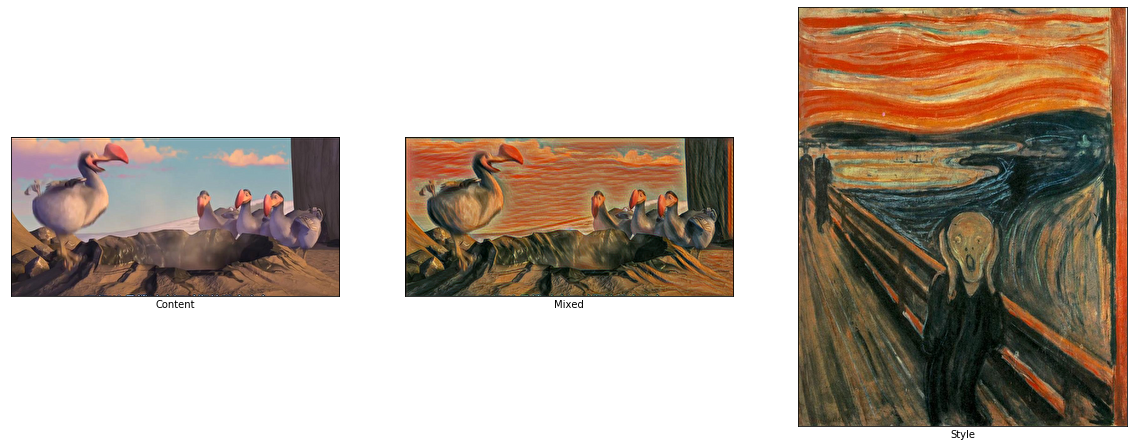

In [0]:
# use pre_trained model to generate stylized image
INPUT_PATH = '/content/drive/My Drive/MML/image/content/movie/1.jpg'
OUTPUT_PATH = '/content/drive/My Drive/MML/image/stylized/1_la_muse.jpg'
CHECKPOINT_DIR = '/content/drive/My Drive/MML/Fast Style Transfer Models/scream.ckpt'
STYLE_PATH = '/content/drive/My Drive/MML/image/style/The Scream by Edvard Munch (1893).jpg' # Optional. Only for displaying it.

# Run the code.
feed_forward(INPUT_PATH, OUTPUT_PATH, CHECKPOINT_DIR, STYLE_PATH)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/wave.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


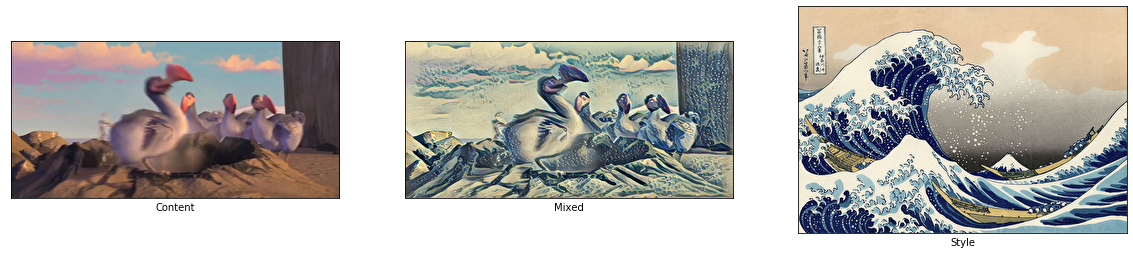

In [0]:
# use pre_trained model to generate stylized image
INPUT_PATH = '/content/drive/My Drive/MML/image/content/movie/3.jpg'
OUTPUT_PATH = '/content/drive/My Drive/MML/image/stylized/1_la_muse.jpg'
CHECKPOINT_DIR = '/content/drive/My Drive/MML/Fast Style Transfer Models/wave.ckpt'
STYLE_PATH = '/content/drive/My Drive/MML/image/style/The_Great_Wave_off_Kanagawa.jpg' # Optional. Only for displaying it.

# Run the code.
feed_forward(INPUT_PATH, OUTPUT_PATH, CHECKPOINT_DIR, STYLE_PATH)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/udnie.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


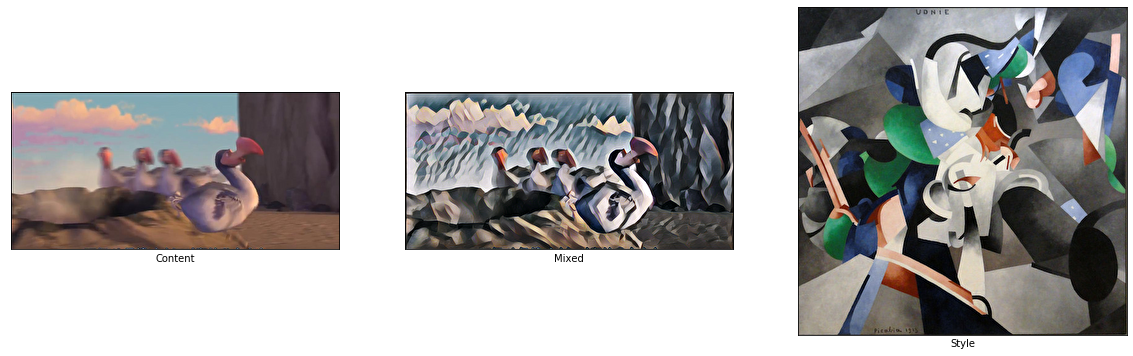

In [0]:
# use pre_trained model to generate stylized image
INPUT_PATH = '/content/drive/My Drive/MML/image/content/movie/4.jpg'
OUTPUT_PATH = '/content/drive/My Drive/MML/image/stylized/1_la_muse.jpg'
CHECKPOINT_DIR = '/content/drive/My Drive/MML/Fast Style Transfer Models/udnie.ckpt'
STYLE_PATH = '/content/drive/My Drive/MML/image/style/udnie.jpg' # Optional. Only for displaying it.

# Run the code.
feed_forward(INPUT_PATH, OUTPUT_PATH, CHECKPOINT_DIR, STYLE_PATH)

In [0]:
from moviepy.editor import VideoFileClip
import cv2
import glob

In [0]:
my_clip = VideoFileClip('/content/drive/My Drive/MML/image/content/movie/frozen2_clip1.mp4', audio=False)
print("Duration of video : ", my_clip.duration)
print("FPS : ", my_clip.fps)

Duration of video :  6.34
FPS :  23.976023976023978


In [0]:
my_clip.size

[1280, 720]

In [0]:
my_clip.iter_frames(fps=24, dtype='uint8')

<generator object Clip.iter_frames.<locals>.generator at 0x7f2582951678>

In [0]:
# Directly write np.array images to video, the color looks weird
OUTPUT_DIR = '/content/drive/My Drive/MML/image/content/movie/stylized_movie/'
CHECKPOINT_DIR = '/content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt'

size = (my_clip.size[0], my_clip.size[1])
i = 0
out = cv2.VideoWriter('/content/drive/My Drive/MML/image/content/movie/stylized_movie/frozen_stylized_1.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 24, size)
for frame in my_clip.iter_frames(fps=24, dtype='uint8'):
  OUTPUT_PATH = os.path.join(OUTPUT_DIR, str(i)+'.jpg')
  stylized_frame = feed_forward(frame, OUTPUT_PATH, CHECKPOINT_DIR, None, movie=True)
  image = np.clip(stylized_frame, 0.0, 255.0)
  # Convert to bytes.
  image = image.astype(np.uint8)
  out.write(image)
  i += 1
out.release()

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fa

In [0]:
# Save stylized images to a folder
OUTPUT_DIR = '/content/drive/My Drive/MML/image/content/movie/stylized_movie/'
CHECKPOINT_DIR = '/content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt'

size = (my_clip.size[0], my_clip.size[1])
i = 0
for frame in my_clip.iter_frames(fps=24, dtype='uint8'):
  output_path = os.path.join(OUTPUT_DIR, str(i)+'.jpg')
  stylized_frame = feed_forward(frame, OUTPUT_PATH, CHECKPOINT_DIR, None, movie=True)
  save_image(stylized_frame, output_path)
  i += 1
out.release()

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fast Style Transfer Models/rain_princess.ckpt
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MML/Fa

In [0]:
# transfer images to video
img_array = []
for filename in glob.glob('/content/drive/My Drive/MML/image/content/movie/stylized_movie/image/*.jpg'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('/content/drive/My Drive/MML/image/content/movie/stylized_movie/ice_age_stylized_0.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 24, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()